In [6]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Simulation parameters
resolution = 10  # pixels/um
pml_thickness = 2
cell_x = 16
cell_y = 16
cell_z = 16

sphere_radius = 1.0
sphere_eps = 2.56
substrate_eps = 2.56
frequency = 1.0

cell_size = mp.Vector3(cell_x, cell_y, cell_z)

# Plane wave incidence defined by polar and azimuthal angles (in degrees)
theta_deg = 10  # Polar angle from +Z
phi_deg = 0    # Azimuthal angle in x–y plane

# Convert to radians
theta = np.radians(theta_deg)
phi = np.radians(phi_deg)

# Build normalized k-vector
k_unit = mp.Vector3(
    np.sin(theta) * np.cos(phi),
    np.sin(theta) * np.sin(phi),
    -np.cos(theta)  # negative for downward propagation
)

# Scale for Meep's eig_kpoint (|k| = frequency in Meep units)
eig_kpoint = k_unit.scale(frequency)


In [8]:
# Materials
default_material = mp.Medium(index=1.0)
cylinder = mp.Cylinder(
    radius=1.0,
    height=mp.inf,               # infinite in Y
    axis=mp.Vector3(0, 1, 0),                   # aligned along the Y-axis
    center=mp.Vector3(0, 0, 1),  # adjust z-position if needed
    material=mp.Medium(epsilon=2.56)
)


substrate = mp.Block(
    center=mp.Vector3(0, 0, -cell_z/4),
    size=mp.Vector3(mp.inf, mp.inf, cell_z/2),
    material=mp.Medium(epsilon=substrate_eps)
)

geometry = [cylinder, substrate]

# Source: downward plane wave at angles
sources = [
    mp.EigenModeSource(
        src=mp.ContinuousSource(frequency=frequency),
        center=mp.Vector3(0, 0, 0.5 * cell_z - pml_thickness - 1),
        size=mp.Vector3(cell_x, cell_y, 0),
        direction=mp.Z,  # still Z, but mode defines propagation
        eig_kpoint=eig_kpoint,
        eig_band=1,
        eig_match_freq=True
    )
]


# PMLs on all sides
pml_layers = [
    mp.PML(thickness=pml_thickness, direction=mp.X),
    mp.PML(thickness=pml_thickness, direction=mp.Y),
    mp.PML(thickness=pml_thickness, direction=mp.Z),
]

# Simulation object
sim = mp.Simulation(
    cell_size=cell_size,
    resolution=resolution,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=sources,
    default_material=default_material
)

# Add flux monitors (six directions)
flux_regions = {
    'top':    mp.FluxRegion(center=mp.Vector3(0, 0, 0.5*cell_z - pml_thickness - 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'bottom': mp.FluxRegion(center=mp.Vector3(0, 0, -0.5*cell_z + pml_thickness + 0.1), size=mp.Vector3(cell_x, cell_y, 0)),
    'left':   mp.FluxRegion(center=mp.Vector3(-0.5*cell_x + pml_thickness + 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'right':  mp.FluxRegion(center=mp.Vector3(0.5*cell_x - pml_thickness - 0.1, 0, 0), size=mp.Vector3(0, cell_y, cell_z)),
    'front':  mp.FluxRegion(center=mp.Vector3(0, -0.5*cell_y + pml_thickness + 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
    'back':   mp.FluxRegion(center=mp.Vector3(0, 0.5*cell_y - pml_thickness - 0.1, 0), size=mp.Vector3(cell_x, 0, cell_z)),
}

flux_monitors = {name: sim.add_flux(frequency, 0, 1, region)
                 for name, region in flux_regions.items()}


# Run the simulation
sim.run(until=60)


-----------
Initializing structure...
time for choose_chunkdivision = 0.0066359 s
Working in 3D dimensions.
Computational cell is 16 x 16 x 16 with resolution 10
     cylinder, center = (0,0,1)
          radius 1, height 1e+20, axis (0, 1, 0)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
     block, center = (0,0,-4)
          size (1e+20,1e+20,8)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.56,2.56,2.56)
time for set_epsilon = 15.85 s
-----------
MPB solved for frequency_1(0.173648,0,-0.984808) = 0.984905 after 131 iters
MPB solved for frequency_1(0.173648,0,-0.999904) = 1 after 1 iters
MPB solved for frequency_1(0.173648,0,-0.999904) = 1 after 1 iters
Meep progress: 0.05/60.0 = 0.1% done in 8.1s, 9691.6s to go
on time step 1 (time=0.05), 8.08228 s/step
Meep progress: 1.2000000000000002/60.0 = 2.0% done in 12.1s, 595.2s to go
on time step 24 (time=1.2), 0.17656 s/step
Meep progress: 2.3000000000000003/60.0 = 3.8% done

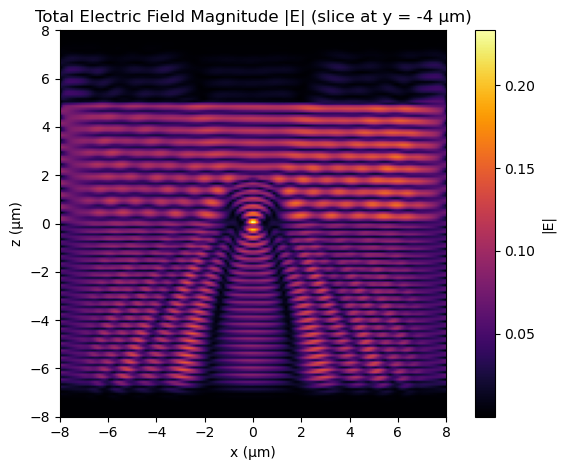

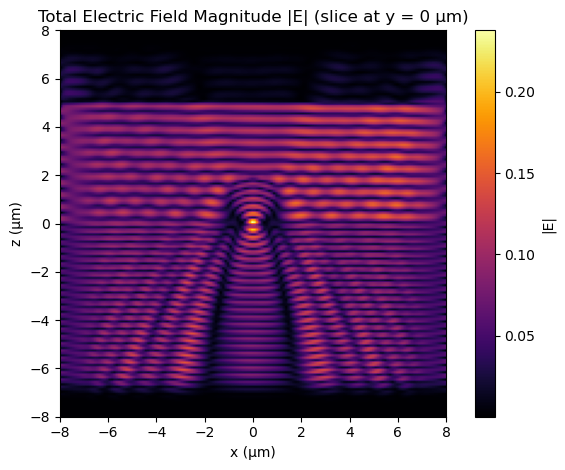

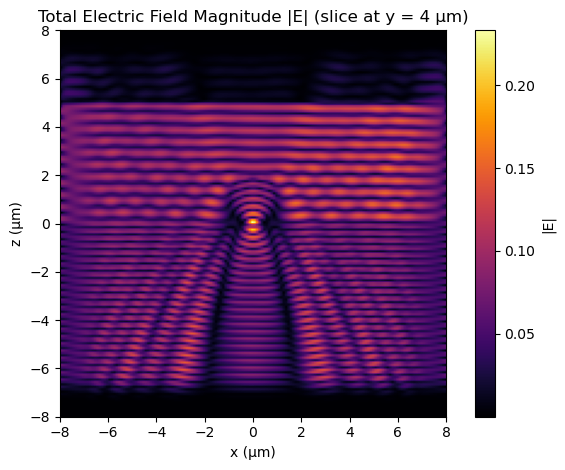

In [9]:
# Slices to visualize (in µm)
y_slices = [-4, 0, 4]  # You can change or extend this list

for x_val in y_slices:
    # Get all field components for slice at y = x_val
    ex = sim.get_array(center=mp.Vector3(0, x_val, 0), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ex)
    ey = sim.get_array(center=mp.Vector3(0, x_val, 0), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ey)
    ez = sim.get_array(center=mp.Vector3(0, x_val, 0), size=mp.Vector3(cell_x, 0, cell_z), component=mp.Ez)

    abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

    # Plot total field magnitude
    plt.figure(dpi=100)
    plt.imshow(abs_E.T, cmap='inferno', origin='lower',
               extent=[-cell_x/2, cell_x/2, -cell_z/2, cell_z/2])
    plt.colorbar(label='|E|')
    plt.xlabel('x (µm)')
    plt.ylabel('z (µm)')
    plt.title(f'Total Electric Field Magnitude |E| (slice at y = {x_val} µm)')
    plt.tight_layout()
    plt.show()


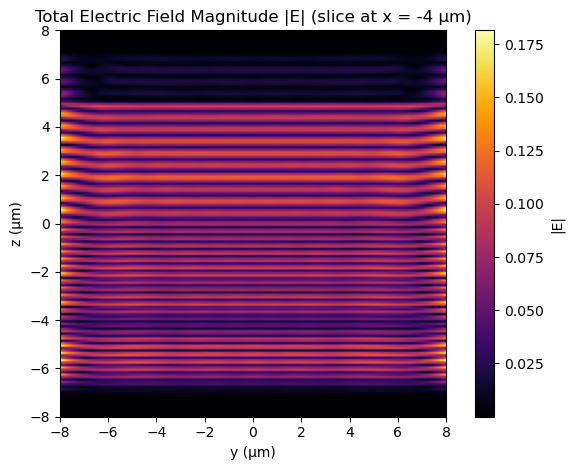

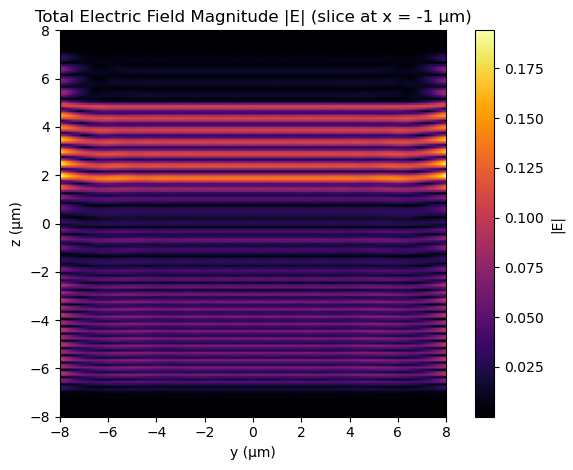

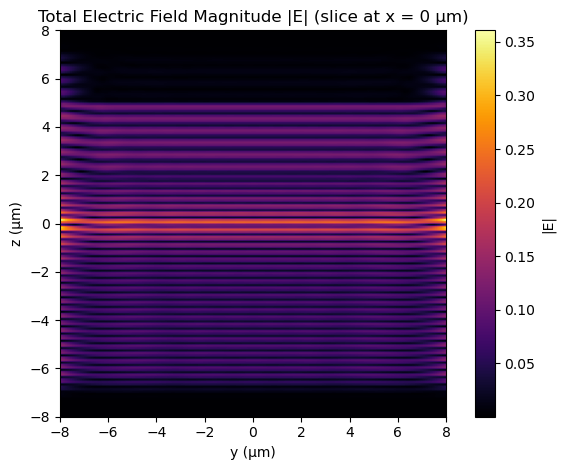

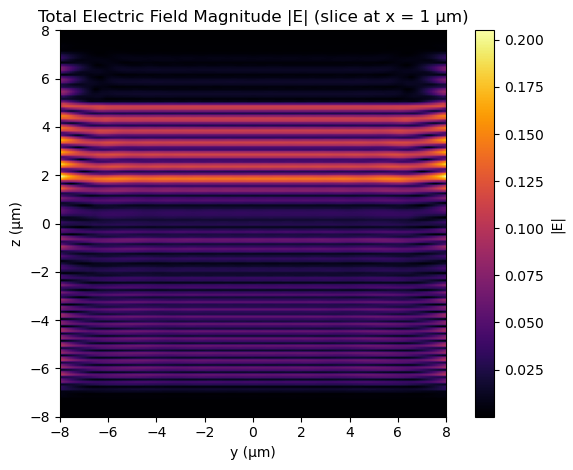

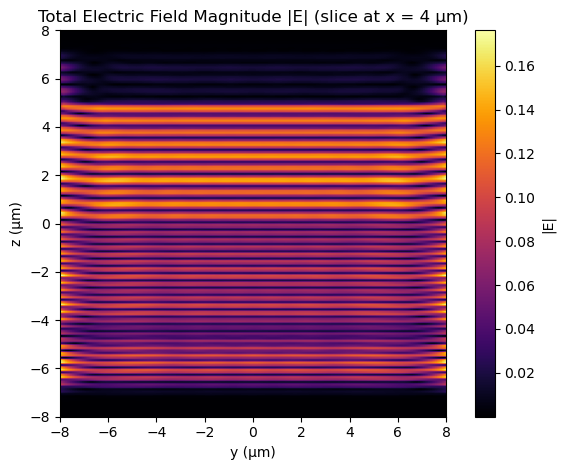

In [10]:
# Slices to visualize (in µm) — fixed x positions
x_slices = [-4, -1, 0, 1, 4]

for x_val in x_slices:
    # Get all field components for slice at x = x_val
    ex = sim.get_array(center=mp.Vector3(x_val, 0, 0), size=mp.Vector3(0, cell_y, cell_z), component=mp.Ex)
    ey = sim.get_array(center=mp.Vector3(x_val, 0, 0), size=mp.Vector3(0, cell_y, cell_z), component=mp.Ey)
    ez = sim.get_array(center=mp.Vector3(x_val, 0, 0), size=mp.Vector3(0, cell_y, cell_z), component=mp.Ez)

    abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

    # Plot total field magnitude
    plt.figure(dpi=100)
    plt.imshow(abs_E.T, cmap='inferno', origin='lower',
               extent=[-cell_y/2, cell_y/2, -cell_z/2, cell_z/2])
    plt.colorbar(label='|E|')
    plt.xlabel('y (µm)')
    plt.ylabel('z (µm)')
    plt.title(f'Total Electric Field Magnitude |E| (slice at x = {x_val} µm)')
    plt.tight_layout()
    plt.show()


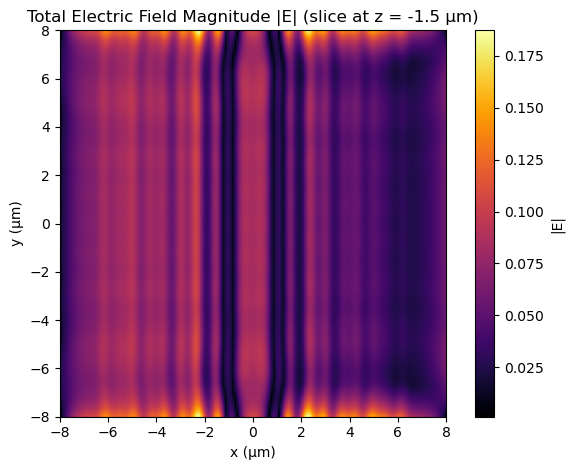

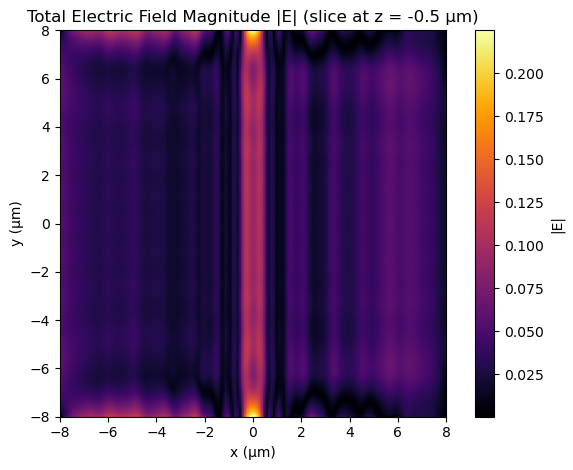

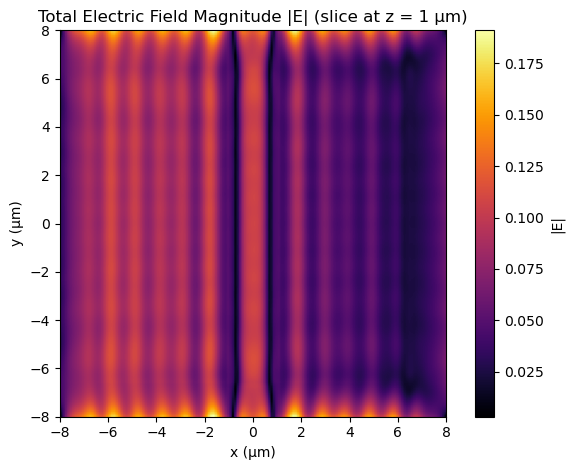

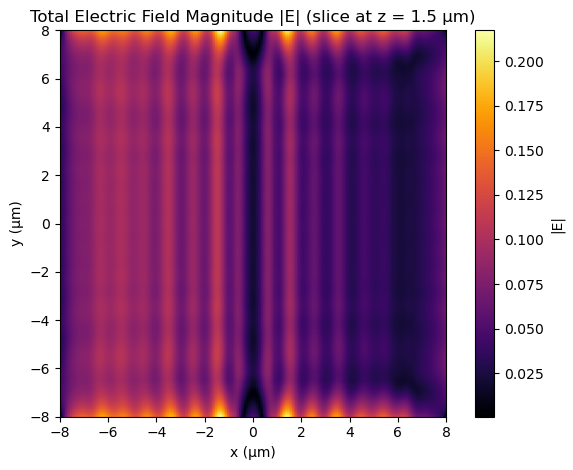

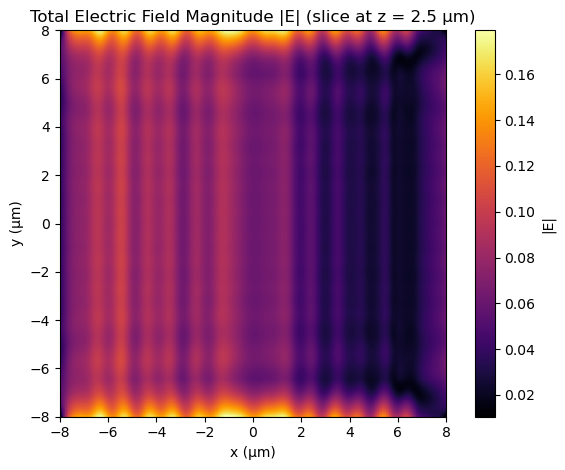

In [11]:
# Slices to visualize (in µm) — fixed z positions
z_slices = [-1.5,-0.5, 1, 1.5, 2.5]

for z_val in z_slices:
    # Get all field components for slice at z = z_val
    ex = sim.get_array(center=mp.Vector3(0, 0, z_val), size=mp.Vector3(cell_x, cell_y, 0), component=mp.Ex)
    ey = sim.get_array(center=mp.Vector3(0, 0, z_val), size=mp.Vector3(cell_x, cell_y, 0), component=mp.Ey)
    ez = sim.get_array(center=mp.Vector3(0, 0, z_val), size=mp.Vector3(cell_x, cell_y, 0), component=mp.Ez)

    abs_E = np.sqrt(np.abs(ex)**2 + np.abs(ey)**2 + np.abs(ez)**2)

    # Plot total field magnitude
    plt.figure(dpi=100)
    plt.imshow(abs_E.T, cmap='inferno', origin='lower',
               extent=[-cell_x/2, cell_x/2, -cell_y/2, cell_y/2])
    plt.colorbar(label='|E|')
    plt.xlabel('x (µm)')
    plt.ylabel('y (µm)')
    plt.title(f'Total Electric Field Magnitude |E| (slice at z = {z_val} µm)')
    plt.tight_layout()
    plt.show()


In [12]:
    # Print flux values
    for name, monitor in flux_monitors.items():
        flux_val = mp.get_fluxes(monitor)[0]
        print(f"Flux through {name}: {flux_val:.6f}")

Flux through top: 16.758692
Flux through bottom: -262.461420
Flux through left: -0.684454
Flux through right: -4.671272
Flux through front: 4.685049
Flux through back: -5.300790
